# Modelos para detectar contratos con adiciones - SECOP I
En este notebook se realiza la prueba de posibles modelos predictivos con los cuales se pretende detectar anomalías en la contratación pública de Bogotá. Se usa como insumo la base de datos SECOP_I_MASTER2.

Base con la cual se proceden a realizar modelos de clasificación binarios para 3 diferentes variables objetivo que determinan si el contrato tuvo alguna adición del respectivo tipo o no; `Marc Adiciones`,`Adiciones en Valor` y `Adiciones en Valor`. Adicionalmente, se realizan modelos con y sin incluir los modelos con prestacion de servicios.

1. **Modelos para Sancion (Marc Sancion)**
2. **Modelos para Adiciones**
    1. Balanceo de clases y selección doble de variables
    2. Pruebas Regresión logística y Bosques Aleatorios
    3. Comparación Modelos
    4. Modelos SIN prestación de servicios
    
- Buscar útilidad de AIC Y BIC para modelos de clasificación y su calculo.https://stackoverflow.com/questions/48185090/how-to-get-the-log-likelihood-for-a-logistic-regression-model-in-sklearn
- Probar elección de hiperparámetros con métrica fbeta.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import scipy.stats as stats
from scipy import stats
from scipy.stats import kruskal
from scipy import stats

import pycorrcat.pycorrcat as corrcat  #Calcula la V de cramer para variables categóricas.

import statsmodels.api as sm

import seaborn as sns
# os.chdir('C:/Users/santiago/Documents/Proyecto AI Veeduría')
os.chdir('C:/Users/juanc/OneDrive/Escritorio/LOCAL_Personal_Veeduria')


# Funciones auxiliares

In [20]:
# Gráficas
def corr_Matrix(data):
    '''
    Gráfica la matríz de correlación entre todas las variables 
    de la base de datos usada.
    '''
    f,ax = plt.subplots(figsize = (15,14))
    sns.heatmap(data.corr(),cmap = 'ocean_r', annot = True, cbar = False )
    ax.set_title('Correlation matrix')
    plt.show()


def plot_ROC(model, X_test, y_test, scaler, model_name='Model'):
    '''
    Gráfica la curva ROC y calcula el AUC para un modelo entrenado dados unos datos de prueba.
    Entradas:
            model: modelo sklearn entrenado del que se usa el método predict_proba()
            X_test: variables independientes de prueba.
            Y_test: variable dependiente de prueba.
            scaler: objeto preprocessing.StandardScaler() entrenado junto al modelo para escalar X_test.
            model_name: string con el nombre del modelo que se pasa para usar como leyenda de la curva ROC
    Salida:
            Gráfica curva ROC e impresión del AUC.
    '''
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(scaler.transform(X_test))
    lr_probs = lr_probs[:, 1]
    
    lr_auc = roc_auc_score(y_test, lr_probs)
    print("Model: ROC AUC = {:1.3f}".format(lr_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle = '--') 
    plt.plot(lr_fpr, lr_tpr, marker = '.', label = model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('ROC curve')
    plt.show()
    
    
def plot_CM(y_true, y_pred,norm=None):
    '''
    Tabla de matríz de confusión
    '''
    cm = confusion_matrix(y_true, y_pred,normalize=norm)
    cm_df = pd.DataFrame(cm, index = ['No','Sí'], columns = ['No','Sí'])
    cm_df.index.name = 'True'; cm_df.columns.name = 'Predicted'
    return cm_df

def balance(base, target):
    '''
    Función para balancear las bases de datos hacia el valor de la variables objetivo con menos observaciones.
    Entradas:
            base: base de pandas a balancear.
            target: nombre de la variable objetivo respecto a la que se balanceará.
    Salida:
            df_downsample: base balanceada.
    '''
    df_majority = base[base[target] == 0]
    df_minority = base[base[target] == 1]
    
    n = min(base[target].value_counts())
    df_majority_downsampled = resample(df_majority, replace = False, n_samples = n, random_state = 123)
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    
    return df_downsampled
def small_balanced_sample(X,y,N):
    """
    Muestrea un subconjunto de la base de datos con n dilas por categoria del target
    Entradas:
        X: matriz de datos 
        y: arreglo de ariable respuesta
        N: numero de muestras a muestrear para cada clase
        
    Salida:
        X_samp, y_samp: matriz de datos muestreada y variable output muestrado
    """
    # Concatenacion de X y output y en una sola tabla
    base = pd.concat([X,pd.DataFrame(y)],axis=1).dropna()    
    # Muestreo de N datos por columna
    base_new = base.groupby(y.name).sample(n=N,random_state=1)
    # Shuffle
    base_new = base_new.sample(frac=1).reset_index(drop=True)
    X_samp = base_new.iloc[:,:-1] # Todas las columnas excepto la ultima donde esta el target
    y_samp = base_new[y.name]
    return X_samp, y_samp

In [3]:
# Funciones para ejecutar modelos
def feature_selection(X, y,max_vars,umbral = -np.inf):
    '''
    Selección de variables estadísticamente significativas mediante random forest
    Entradas: X, y: Variables independietes y dependientes como base y serie de pandas respectivamente.
    Salida: X_varSelec: Pandas dataframe solo con las variables significativas.
    '''
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 100),max_features = max_vars,threshold=-np.inf)
    sel.fit(X, y)
    
    variables_significativas = np.where(sel.get_support() == True)
    nombres_columnas = []
    for idx, i in enumerate(variables_significativas):
        nombres_columnas.append(X.columns[i])
    nombres_columnas = list(nombres_columnas[0])
    print("Variables estadísticamente significativas: \n{}".format(nombres_columnas))
    
    X_varSelec = sel.transform(X)
    X_varSelec = pd.DataFrame(X_varSelec, columns = nombres_columnas)
    
    return X_varSelec


def reg_log(X, y):
    '''
    Modelo de regresión logítica.
    Función para la realización de modelos mediante regresión logística. Imprime accuracy de la validación cruzada
    y datos de prueba , así como el recall en los datos de prueba.
    Entradas: 
            X: base de pandas con variables independientes.
            Y: serie de pandas con la variable objetivo.
    Salidas:
            rl: modelo de regresión logística entrenado.
            X_test, y_test: Datos de prueba.
            y_pred: valores de la variable respuesta estimados.
            scaler: objeto para escalar valores entrenado.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    rl = LogisticRegression(max_iter = 500)
    vc = cross_val_score(rl, scaler.transform(X_train), y_train, cv = 10, scoring = "accuracy")
    accuracy = vc.mean()
    print("Accuracy para Regresión Logística con validación cruzada: {:1.4f} ".format(accuracy) )
    
    rl = LogisticRegression(max_iter = 500)
    rl.fit(scaler.transform(X_train), y_train)

    y_pred = rl.predict(scaler.transform(X_test))
    print("El accuracy del test es: {:1.4f}".format( accuracy_score(y_test, y_pred) ))
    print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test, y_pred) ))
    
    return rl, X_test, y_test, y_pred, scaler


def random_forest(X, y):
    '''
    Modelo random forest para clasificación.
    Entradas: 
            X: base de pandas con variables independientes.
            Y: serie de pandas con la variable objetivo.
    Salidas:
            arb: modelo de random forest entrenado.
            X_test, y_test: Datos de prueba.
            y_pred: valores de la variable respuesta estimados.
            scaler: objeto para escalar valores entrenado.    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    arb = RandomForestClassifier(random_state=42)
    arb.fit(scaler.transform(X_train), y_train)
    
    y_pred_arb = arb.predict(scaler.transform(X_test))
    print("Accuracy del test: {:1.4f}".format( accuracy_score(y_test, y_pred_arb) ))
    print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test, y_pred_arb) ))

    return arb, X_test, y_test, y_pred_arb, scaler

In [4]:
# tarda un poco en leer los datos
df = pd.read_csv("SECOP_I_MASTER2.csv")
df = df.dropna()

In [5]:
# Columnas sobre adiciones
cols_ad = [n for n in df.columns if "Adicion" in n or "adicion" in n]
cols_ad

['Marc Adiciones',
 'Adicion en Valor',
 'Adicion en Tiempo',
 'Tiempo Adiciones (Dias)',
 'Valor Total de Adiciones',
 'Valor Contrato con Adiciones']

In [6]:
# Dimension y nombre de columnas
print("Dimension de los datos: ",df.shape)
df.columns

Dimension de los datos:  (603450, 49)


Index(['UID', 'Orden Entidad', 'Nombre de la Entidad', 'Código de la Entidad',
       'Tipo de Proceso', 'Estado del Proceso',
       'Causal de Otras Formas de Contratacion Directa',
       'Regimen de Contratacion', 'Objeto a Contratar', 'Tipo de Contrato',
       'cantidad de palabras objeto a contratar', 'Nombre Grupo',
       'Nombre Familia', 'Nombre Clase', 'EsPostConflicto', 'Def Origen Recur',
       'Num Origenes Recur', 'Descrip Origenes Recur', 'ID Ajudicacion',
       'Tipo Identifi del Contratista',
       'cantidad de palabras objeto del contrato a la Firma',
       'mismo detalle objeto a contratar despues de firma',
       'Identificacion del Contratista', 'Nom Raz Social Contratista',
       'Dpto y Muni Contratista', 'Fecha de Cargue en el SECOP',
       'Fecha de Firma del Contrato', 'Fecha Ini Ejec Contrato',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Fecha Ini Ejec - Fecha Firma Contrato', 'Mes Firma Contrato',
       'Dia del Mes Firma Contrato',

# Identificación de variables

In [7]:
#Variables a excluir al momento de entrenar modelos
vars_a_excluir = ["Orden Entidad","Estado del Proceso", "Nombre Familia",
                  "Nombre Clase","Nombre Sub Unidad Ejecutora","Moneda","Cuantia Proceso",
                  "Valor Contrato con Adiciones","Objeto a Contratar","Num Origenes Recur",
                 ]
# Variables que no son utiles para modelos
vars_a_excluir += ["UID","Nombre de la Entidad","Código de la Entidad","Descrip Origenes Recur",
                      "ID Ajudicacion","Tipo Identifi del Contratista","Identificacion del Contratista",
                     "Nom Raz Social Contratista","Fecha de Cargue en el SECOP","Fecha de Firma del Contrato",
                     "Fecha Ini Ejec Contrato","Fecha Ini Ejec Contrato","Fecha Fin Ejec Contrato"
                     ,'Ultima Actualizacion']
# vars_inluidas contiene los target
vars_incluidas = [name for name in df.columns if name not in vars_a_excluir]
# Marc Sancion como input es exluido
vars_categoricas = ["Tipo de Proceso","Causal de Otras Formas de Contratacion Directa","Regimen de Contratacion",
                    "Tipo de Contrato","Nombre Grupo","EsPostConflicto","Def Origen Recur",
                    "mismo detalle objeto a contratar despues de firma","Dpto y Muni Contratista","Mes Firma Contrato",
                   "Dia del Mes Firma Contrato","Dia de la Semana Firma Contrato","Marc Adiciones",]

### Dudas
- Las variables en formato fecha fueron incluidas como inputs en el modelo?
-  EsPostConflicto el desbalance es enorme, dejarla?
-  Diccionario de variables que quedaron en SECOP_1_MASTER2
- Departamento de Contratista hay unos pocos que vienen de municipios externos a Bogotá y Cundinamarca, dejarlos?
- Tiempo Adiciones (Dias) tiene datos negativos

In [8]:
print("Para Marc Adiciones:")
print(df["Marc Adiciones"].value_counts(),"\n \n")
print("Para Adicion en Valor:")
print(df["Adicion en Valor"].value_counts(),"\n \n")
print("Para Adicion en Tiempo:")
print(df["Adicion en Tiempo"].value_counts(),"\n \n")

Para Marc Adiciones:
0    451492
1    151958
Name: Marc Adiciones, dtype: int64 
 

Para Adicion en Valor:
0    461486
1    141964
Name: Adicion en Valor, dtype: int64 
 

Para Adicion en Tiempo:
0    460338
1    143112
Name: Adicion en Tiempo, dtype: int64 
 



Aunque el desbalance no es tan drástico como con `Marc Sancion` sí se mantiene un desbalance de 3 a 1 aproximadamente siendo la categroría 1 la menos presente para los 3 outputs. Por lo tanto, para cada output de adición se hará un downsampling de la clase 0 mientras que se mantiene intacta la cantidad de datos de la clase 1.

Primero se balanceará los datos para que tengan unos resultante se seleccionarán entre 10000 y 15000 datos de cada clase para ejecutar los modelos manteniendo el balance y que se ejecuten rápido los modelos.

# 1. Modelos con output `Marc Adiciones`
- Se exluye la informacion acerca de adiciones excepto el target 'Marc Adiciones'.
- **Se excluye la información acerca de sanciones, es decir 'Marc Sancion y Valor Sancion'**

In [9]:
# _MA: para Marc Adiciones
df_downsampled_MA = balance(df,"Marc Adiciones")
y_down_MA = df_downsampled_MA["Marc Adiciones"]
# Eliminamos las columnas innecesarias incluyendo la del target
X_down_MA = df_downsampled_MA.drop(columns = vars_a_excluir + ["Marc Adiciones","Adicion en Valor","Adicion en Tiempo",
                                                             "Marc Sancion","Valor Total de Adiciones"])
# Pasamos a dummies las columnas que sean categoricas
X_down_MA_dum = pd.get_dummies(data = X_down_MA, columns=list(set(vars_categoricas) - {"Marc Adiciones","Marc Sancion"}))

In [10]:
print("Variables iniciales para modelos:")
print(list(X_down_MA.columns))
print("Variables dummies iniciales")
# No esta quitando Valor Sancion :(
# Variables dummies
# print(list(X_down_MA_dum.columns))

Variables iniciales para modelos:
['Tipo de Proceso', 'Causal de Otras Formas de Contratacion Directa', 'Regimen de Contratacion', 'Tipo de Contrato', 'cantidad de palabras objeto a contratar', 'Nombre Grupo', 'EsPostConflicto', 'Def Origen Recur', 'cantidad de palabras objeto del contrato a la Firma', 'mismo detalle objeto a contratar despues de firma', 'Dpto y Muni Contratista', 'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'Mes Firma Contrato', 'Dia del Mes Firma Contrato', 'Dia de la Semana Firma Contrato', 'Plazo en dias de Ejec del Contrato', 'Tiempo Adiciones (Dias)', 'Cuantia Contrato', 'Valor Sancion', 'Ultima Actualizacion - Fecha Fin Ejec Contrato']
Variables dummies iniciales


## Seleccion de las variables mas importantes con Random Forest
Para seleccionar las variables utilizamos todos los datos después de balanceo.

In [11]:
print("Dimension de dataset con dummies: ",X_down_MA_dum.shape)

Dimension de dataset con dummies:  (303916, 209)


### Primera selección de variables
Se selecciona las variables más importantes con Random Forest sobre el dataset de dummies

In [12]:
# Tarda un poco
max_vars = 30
X_fselec = feature_selection(X_down_MA_dum, y_down_MA, max_vars)

Variables estadísticamente significativas: 
['cantidad de palabras objeto a contratar', 'cantidad de palabras objeto del contrato a la Firma', 'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'Plazo en dias de Ejec del Contrato', 'Tiempo Adiciones (Dias)', 'Cuantia Contrato', 'Ultima Actualizacion - Fecha Fin Ejec Contrato', 'Dpto y Muni Contratista_Bogotá D.C.', 'Dpto y Muni Contratista_Cundinamarca', 'Causal de Otras Formas de Contratacion Directa_Prestación de Servicios Profesionales y de Apoyo a la Gestión (Literal H)', 'Tipo de Proceso_Contratación Directa (Ley 1150 de 2007)', 'Tipo de Proceso_Régimen Especial', 'Dia del Mes Firma Contrato_1', 'Dia del Mes Firma Contrato_2', 'Nombre Grupo_[F] Servicios', 'Def Origen Recur_0', 'Def Origen Recur_1', 'Mes Firma Contrato_Diciembre', 'Mes Firma Contrato_Enero', 'Mes Firma Contrato_Marzo', 'Mes Firma Contrato_Noviembre', 'Mes Firma Contrato_Octubre', 'Tipo de Contrato_Prestación de Servicios', 'Dia d

In [13]:
print("Variables categoricas seleccionadas, 1era selección:")
cat_set = set()
for v in vars_categoricas:
    for col in X_fselec.columns:
        if v in col:
            cat_set = cat_set.union({v})
print(cat_set)
print("\n \n \n")
num_set = set()
for v in (set(X_down_MA) - set(vars_categoricas)):
    for col in X_fselec.columns:
        if v in col:
            num_set = num_set.union({v})
print("Variables numericas seleccionadas, 1era selección:")
print(num_set)

Variables categoricas seleccionadas, 1era selección:
{'Dpto y Muni Contratista', 'Causal de Otras Formas de Contratacion Directa', 'Tipo de Proceso', 'Dia del Mes Firma Contrato', 'Nombre Grupo', 'Def Origen Recur', 'Mes Firma Contrato', 'Tipo de Contrato', 'Dia de la Semana Firma Contrato', 'Regimen de Contratacion'}

 
 

Variables numericas seleccionadas, 1era selección:
{'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'cantidad de palabras objeto del contrato a la Firma', 'Ultima Actualizacion - Fecha Fin Ejec Contrato', 'Cuantia Contrato', 'cantidad de palabras objeto a contratar', 'Plazo en dias de Ejec del Contrato', 'Tiempo Adiciones (Dias)'}


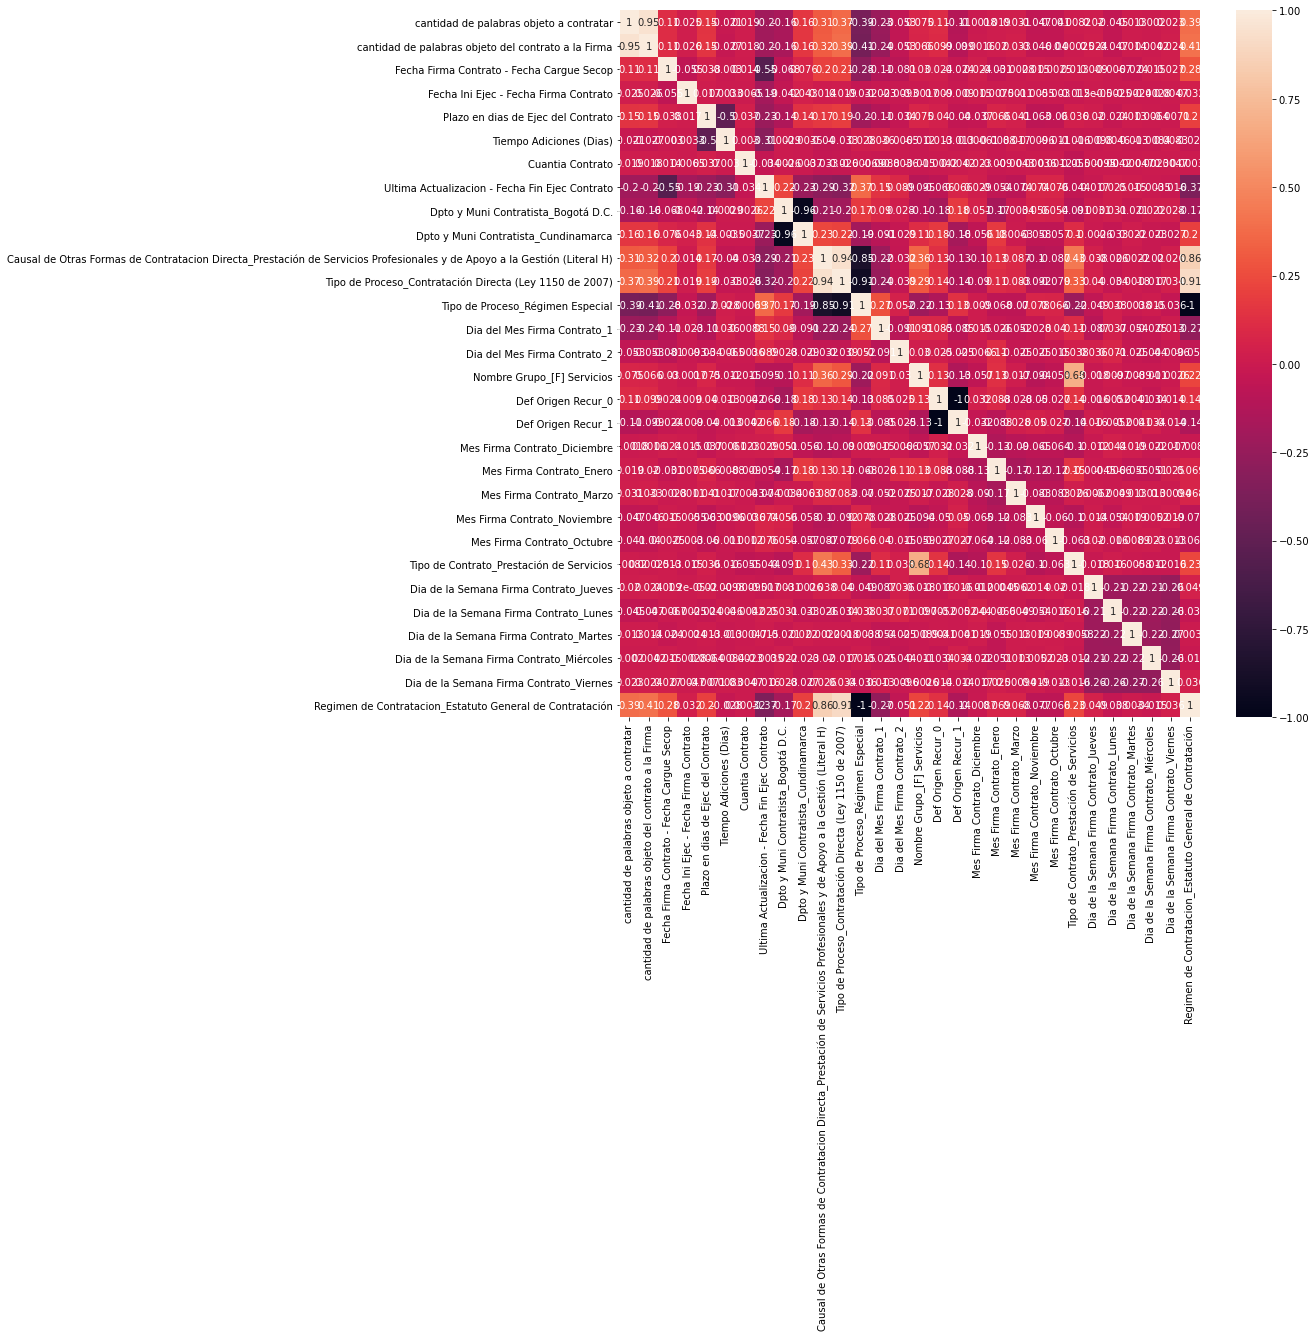

In [14]:
fig = plt.figure(figsize=(13,13))
sns.heatmap(X_fselec.corr(),annot=True);
#plt.xticks(np.arange(8),rotation=20);

In [15]:
max_vars_2 = 15
X_fselec_2 = feature_selection(X_fselec, y_down_MA,max_vars_2)

Variables estadísticamente significativas: 
['cantidad de palabras objeto a contratar', 'cantidad de palabras objeto del contrato a la Firma', 'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'Plazo en dias de Ejec del Contrato', 'Tiempo Adiciones (Dias)', 'Cuantia Contrato', 'Ultima Actualizacion - Fecha Fin Ejec Contrato', 'Causal de Otras Formas de Contratacion Directa_Prestación de Servicios Profesionales y de Apoyo a la Gestión (Literal H)', 'Tipo de Proceso_Régimen Especial', 'Dia del Mes Firma Contrato_1', 'Nombre Grupo_[F] Servicios', 'Mes Firma Contrato_Enero', 'Tipo de Contrato_Prestación de Servicios', 'Regimen de Contratacion_Estatuto General de Contratación']


In [16]:
print("Variables categoricas seleccionadas, 2da selección:")
cat_set = set()
for v in vars_categoricas:
    for col in X_fselec_2.columns:
        if v in col:
            cat_set = cat_set.union({v})
print(cat_set)
print("\n \n \n")
num_set = set()
for v in (set(X_down_MA) - set(vars_categoricas)):
    for col in X_fselec_2.columns:
        if v in col:
            num_set = num_set.union({v})
print("Variables numericas seleccionadas, 2da selección:")
print(num_set)

Variables categoricas seleccionadas, 2da selección:
{'Nombre Grupo', 'Mes Firma Contrato', 'Tipo de Contrato', 'Causal de Otras Formas de Contratacion Directa', 'Tipo de Proceso', 'Regimen de Contratacion', 'Dia del Mes Firma Contrato'}

 
 

Variables numericas seleccionadas, 2da selección:
{'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'cantidad de palabras objeto del contrato a la Firma', 'Ultima Actualizacion - Fecha Fin Ejec Contrato', 'Cuantia Contrato', 'cantidad de palabras objeto a contratar', 'Plazo en dias de Ejec del Contrato', 'Tiempo Adiciones (Dias)'}


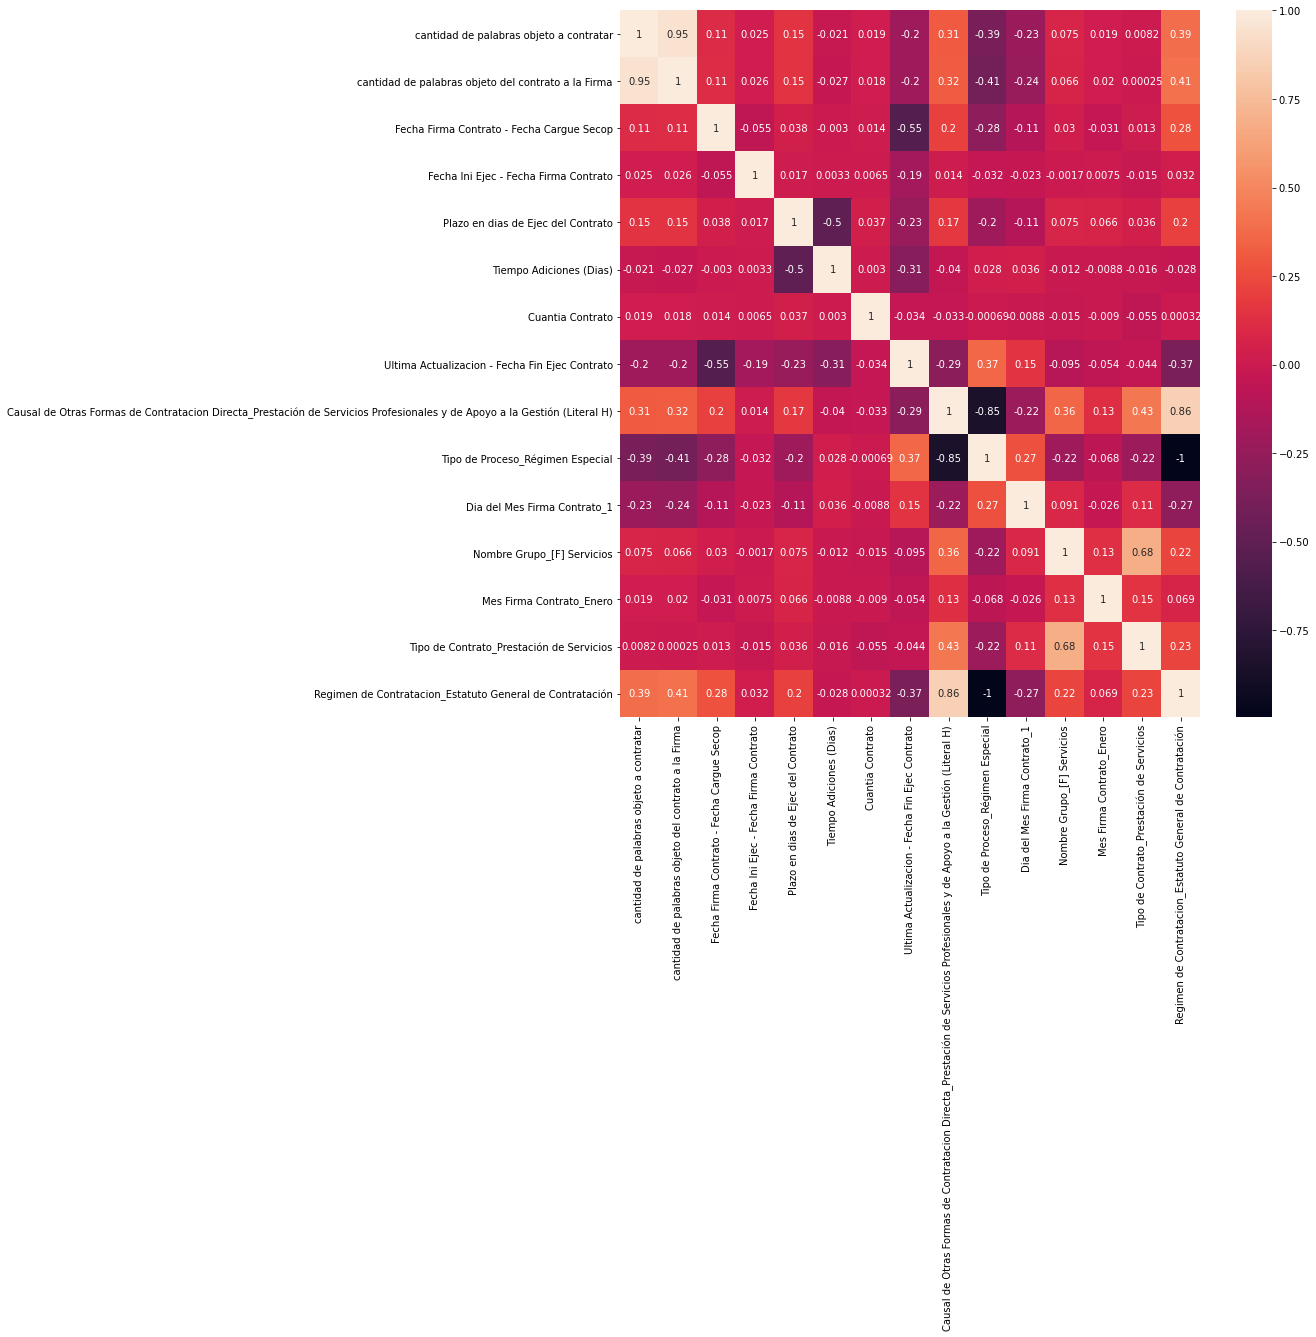

In [17]:
fig = plt.figure(figsize=(13,13))
sns.heatmap(X_fselec_2.corr(),annot=True);
#plt.xticks(np.arange(8),rotation=20);

## Modelos con pocas cantidad de filas reducida

In [25]:
print("Datos iniciales por clase")
print(y_down_MA.value_counts())
N = 15000 # 150000 por clase
X_MA, y_MA = small_balanced_sample(X_down_MA_dum,y_down_MA,N)

Datos iniciales por clase
1    151958
0    151958
Name: Marc Adiciones, dtype: int64


## Regresion Logistica

### Con todas las variables

In [27]:
X_train_MA, X_test_MA, y_train_MA, y_test_MA = train_test_split(X_MA, y_MA, test_size=0.33, random_state=42)

In [31]:
# Escalador de datos
scaler = preprocessing.StandardScaler().fit(X_train_MA)
# Validacion cruzada
reglog = LogisticRegression(max_iter = 500)
vc = cross_val_score(reglog, scaler.transform(X_train_MA), y_train_MA, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Regresión Logística con validación cruzada: {:1.4f} ".format(accuracy) )

Accuracy para Regresión Logística con validación cruzada: 0.6917 


In [32]:
reglog = LogisticRegression(max_iter=500)
reglog.fit(scaler.transform(X_train_MA),y_train_MA)

LogisticRegression(max_iter=500)

In [33]:
y_pred = reglog.predict(scaler.transform(X_test_MA))
print("El accuracy del test es: {:1.4f}".format( accuracy_score(y_test_MA, y_pred) ))
print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test_MA, y_pred) ))

El accuracy del test es: 0.6960
La sensitividad(recall) del test es: 0.6846


In [35]:
plot_CM(y_test_MA, y_pred,norm='true')

Predicted,No,Sí
True,,
No,0.707297,0.292703
Sí,0.315364,0.684636


Model: ROC AUC = 0.777


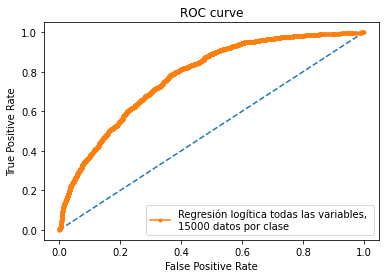

In [39]:
plot_ROC(reglog, X_test_MA, y_test_MA, scaler, model_name='Regresión logítica todas las variables, \n'+str(N)+" datos por clase")

### Regresión logística con primera selección de variables

In [41]:
# Primero reducimos la cantidad de filas 
N = 15000 # 150000 por clase
X_fselec_MA, y_fselec_MA = small_balanced_sample(X_fselec,y_down_MA,N)

In [43]:
# Escalador de datos
scaler2 = preprocessing.StandardScaler().fit(X_fselec_MA)
# Validacion cruzada
reglog2 = LogisticRegression(max_iter = 500)
vc = cross_val_score(reglog2, scaler2.transform(X_fselec_MA), y_fselec_MA, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Regresión Logística con validación cruzada, 1era SELECCION DE VARIABLES: {:1.4f} ".format(accuracy) )

Accuracy para Regresión Logística con validación cruzada, 1era SELECCION DE VARIABLES: 0.4968 


In [42]:
regLog2, X_test2_MA, y_test2_MA, y_pred2_MA, scaler2_MA = reg_log(X_fselec_MA, y_fselec_MA)

Accuracy para Regresión Logística con validación cruzada: 0.4902 
El accuracy del test es: 0.4894
La sensitividad(recall) del test es: 0.5613


In [44]:
plot_CM(y_test2_MA, y_pred2_MA,norm='true')

Predicted,No,Sí
True,,
No,0.417556,0.582444
Sí,0.438667,0.561333


Model: ROC AUC = 0.490


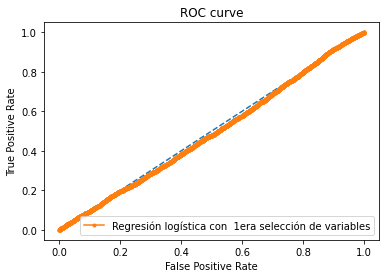

In [45]:
plot_ROC(regLog2, X_test2_MA, y_test2_MA, scaler2_MA, model_name='Regresión logística con  1era selección de variables')